In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

## Importing Data and DateTime index preparation

In [2]:
df = pd.read_csv("data/bicikelj_train.csv")
# Convert the "timespamp" colum to a datetime object and set it as the index
df = df.set_index("timestamp")
df.index = pd.to_datetime(df.index)

# Count the number of duplicate index values
display(df.index.duplicated().sum())

display(df.head())
display(df.info())

0

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,POGAČARJEV TRG-TRŽNICA,KONGRESNI TRG-ŠUBIČEVA ULICA,CANKARJEVA UL.-NAMA,BREG,GRUDNOVO NABREŽJE-KARLOVŠKA C.,MIKLOŠIČEV PARK,BAVARSKI DVOR,TRG OF-KOLODVORSKA UL.,MASARYKOVA DDC,...,POVŠETOVA - KAJUHOVA,SOSESKA NOVO BRDO,TEHNOLOŠKI PARK,VOJKOVA - GASILSKA BRIGADA,GERBIČEVA - ŠPORTNI PARK SVOBODA,DOLENJSKA C. - STRELIŠČE,ROŠKA - STRELIŠKA,LEK - VEROVŠKOVA,VOKA - SLOVENČEVA,SUPERNOVA LJUBLJANA - RUDNIK
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-08-02 13:04:00,17,17,20,26,10,10,16,7,12,2,...,9,7,5,4,2,9,4,8,3,1
2022-08-02 13:10:00,18,17,19,25,10,11,15,7,12,4,...,9,7,5,4,1,9,4,8,2,1
2022-08-02 13:14:00,17,18,19,25,9,11,16,7,12,5,...,9,7,5,4,1,9,4,8,2,1
2022-08-02 13:20:00,18,15,20,26,12,11,18,6,13,1,...,9,7,5,2,1,9,4,8,2,1
2022-08-02 13:25:00,20,16,19,23,12,10,17,6,15,1,...,9,7,5,2,1,9,4,8,2,1


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7739 entries, 2022-08-02 13:04:00 to 2022-10-01 18:23:00
Data columns (total 83 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE    7739 non-null   int64
 1   POGAČARJEV TRG-TRŽNICA                7739 non-null   int64
 2   KONGRESNI TRG-ŠUBIČEVA ULICA          7739 non-null   int64
 3   CANKARJEVA UL.-NAMA                   7739 non-null   int64
 4   BREG                                  7739 non-null   int64
 5   GRUDNOVO NABREŽJE-KARLOVŠKA C.        7739 non-null   int64
 6   MIKLOŠIČEV PARK                       7739 non-null   int64
 7   BAVARSKI DVOR                         7739 non-null   int64
 8   TRG OF-KOLODVORSKA UL.                7739 non-null   int64
 9   MASARYKOVA DDC                        7739 non-null   int64
 10  VILHARJEVA CESTA                      7739 non-null   int64
 11  PARK NA

None

## Creating a DataFrame for each station

In [3]:
# Split the dataframe into multiple dataframes, each with one station
df_list = [df[[station]] for station in df.columns]
df_list[0].head()

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE
timestamp,
2022-08-02 13:04:00,17
2022-08-02 13:10:00,18
2022-08-02 13:14:00,17
2022-08-02 13:20:00,18
2022-08-02 13:25:00,20


### Data distribution of one station

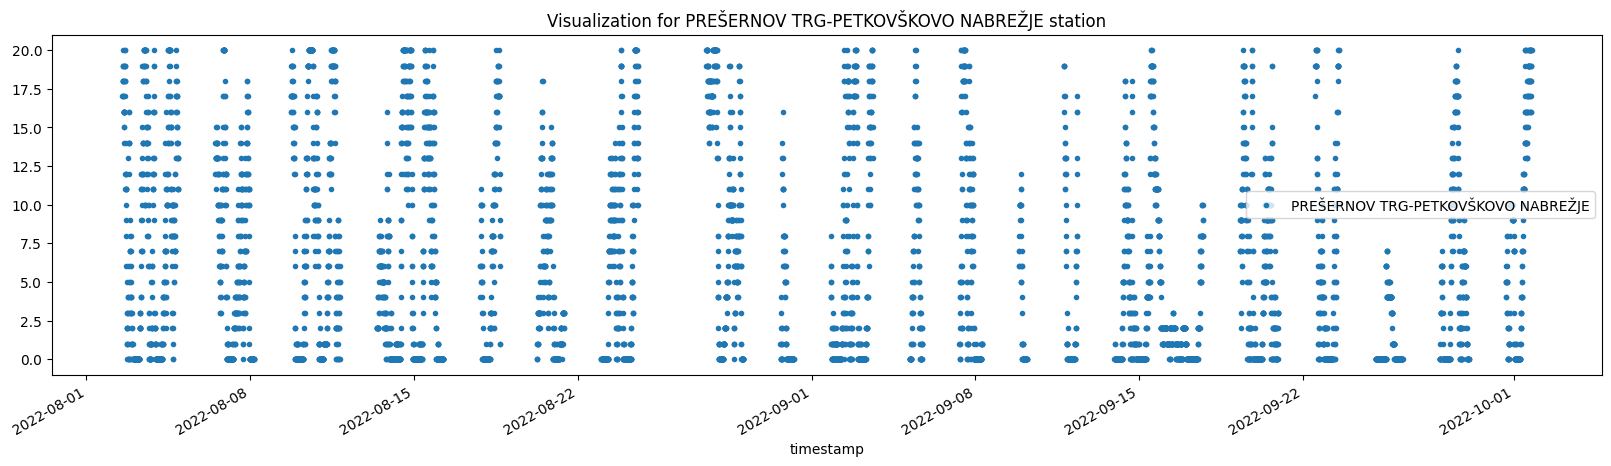

In [4]:
ig, ax = plt.subplots(figsize=(20, 5))
df_list[0].plot(ax=ax, label='Training Set', title=f"Visualization for {df_list[0].columns[0]} station", style=".")
plt.show()

## Time Series Cross Validation Example and Visualization

In [5]:
tss = TimeSeriesSplit(n_splits=10, gap=(60 // 5))
df_list = [station.sort_index() for station in df_list]

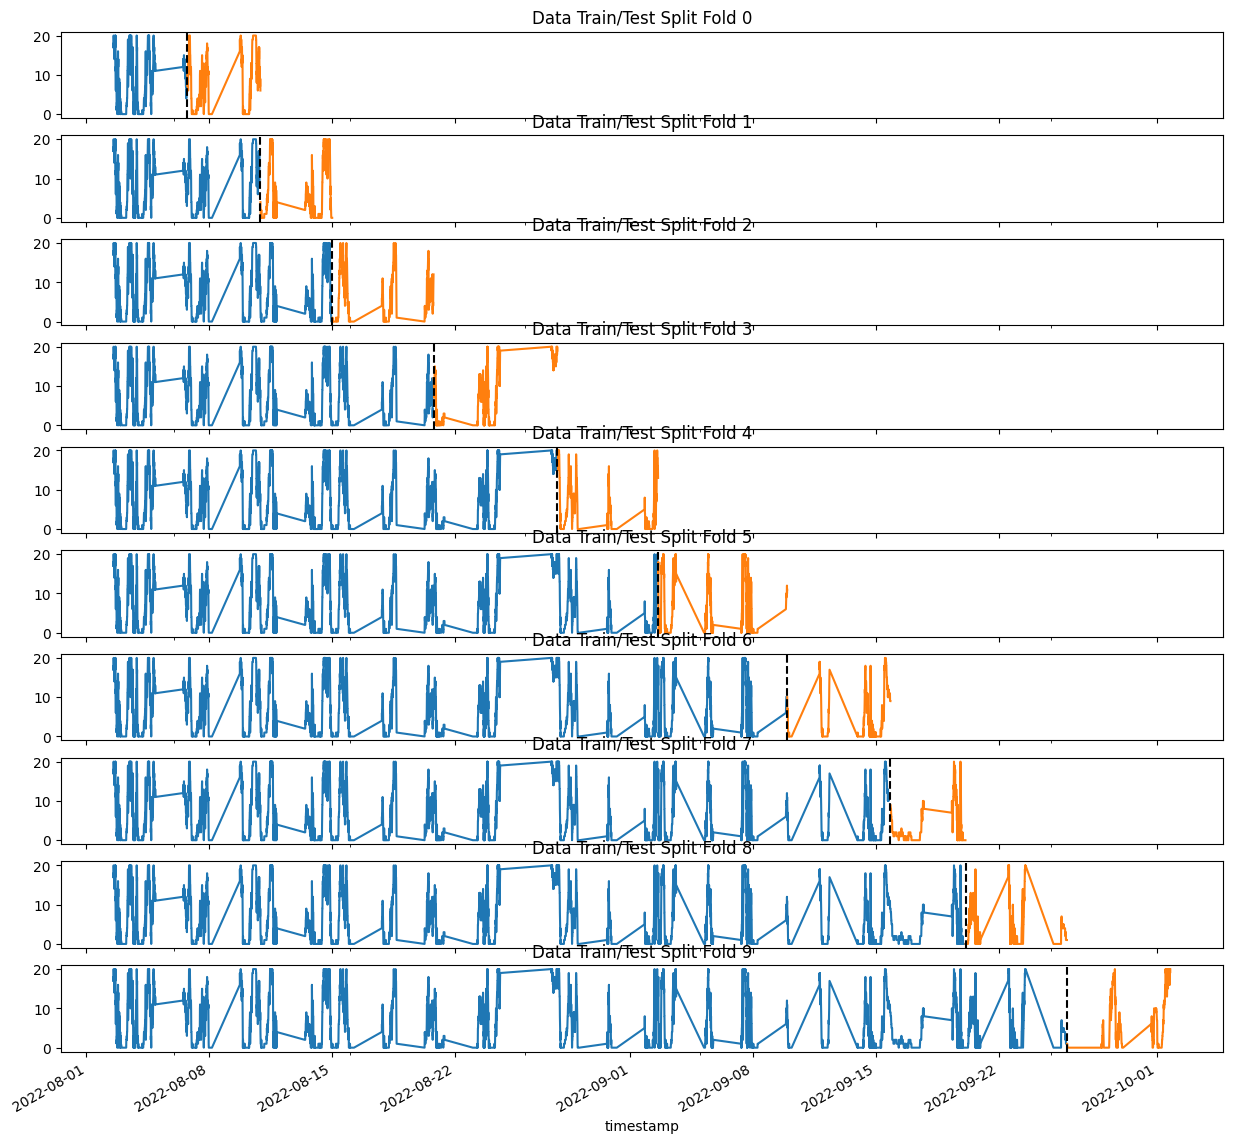

In [6]:
fig, axs = plt.subplots(10, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_list[0]):
    train = df_list[0].iloc[train_idx]
    test = df_list[0].iloc[val_idx]
    train[df_list[0].columns[0]].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test[df_list[0].columns[0]].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# Feature creation

## Features created from datetime index (hour, dayofweek, month, dayofyear, dayofmonth)

In [7]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

df_list = [create_features(station) for station in df_list]
df_list[0].head()

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth
timestamp,,,,,,
2022-08-02 13:04:00,17,13,1,8,214,2
2022-08-02 13:10:00,18,13,1,8,214,2
2022-08-02 13:14:00,17,13,1,8,214,2
2022-08-02 13:20:00,18,13,1,8,214,2
2022-08-02 13:25:00,20,13,1,8,214,2


## Lag features (60, (90) and 120 min lag)

In [8]:
def add_lags(df):
    df = df.copy()
    # Create 60, 90 and 120 minutes lags
    # lags = [60, 90, 120]
    lags = [60, 120]
    for lag in lags:
        df_lag = df.copy()
        # Drop all but the target column
        df_lag = df_lag[[df.columns[0]]]
        # Subtract 60 minutes from the index
        df_lag.index = df_lag.index + pd.Timedelta(minutes=lag)
        # Rename the column to "lag_60"
        df_lag.columns = [f"lag_{lag}"]
        # Merge the dataframe with the lagged dataframe
        df = pd.merge_asof(
            df,
            df_lag,
            left_index=True,
            right_index=True,
            direction="nearest",
            tolerance=pd.Timedelta("15m"),
        )
    return df

df_list = [add_lags(station) for station in df_list]
display(df_list[0].tail())
display(df_list[0].isna().sum())

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth,lag_60,lag_120
timestamp,,,,,,,,
2022-10-01 18:03:00,18,18,5,10,274,1,20.0,19.0
2022-10-01 18:07:00,20,18,5,10,274,1,20.0,19.0
2022-10-01 18:13:00,19,18,5,10,274,1,20.0,18.0
2022-10-01 18:16:00,19,18,5,10,274,1,20.0,18.0
2022-10-01 18:23:00,20,18,5,10,274,1,20.0,18.0


PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE      0
hour                                    0
dayofweek                               0
month                                   0
dayofyear                               0
dayofmonth                              0
lag_60                                191
lag_120                               419
dtype: int64

In [9]:
df_list[0].to_csv("data/other/processed.csv")

## School day feature (0 for holidays and weekends, 1 for school days)

In [10]:
def add_school_days(df):
    # Add vacation feature which is 1 if the day is a school vacation day and 0 otherwise
    # School days are from 1.9.2022 to 31.10.2022 without weekends
    df["vacation"] = 0
    df.loc[(df.index >= "2022-09-01") & (df.index <= "2022-10-31") & (df.index.dayofweek < 5), "vacation"] = 1
    return df

df_list = [add_school_days(station) for station in df_list]
display(df_list[0].tail())

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth,lag_60,lag_120,vacation
timestamp,,,,,,,,,
2022-10-01 18:03:00,18,18,5,10,274,1,20.0,19.0,0
2022-10-01 18:07:00,20,18,5,10,274,1,20.0,19.0,0
2022-10-01 18:13:00,19,18,5,10,274,1,20.0,18.0,0
2022-10-01 18:16:00,19,18,5,10,274,1,20.0,18.0,0
2022-10-01 18:23:00,20,18,5,10,274,1,20.0,18.0,0


## Weather feature (Amount of rain in mm)

In [11]:
weather = pd.read_csv("data/extra/padavine_polurno.csv")
weather = weather.drop(columns=["station_id", "station_name"])
weather["datum"] = pd.to_datetime(weather["datum"])
weather = weather.set_index("datum")
weather.info()

def add_weather(df, weather):
    df = df.copy()
    weather = weather.copy()
    # Add weather features by matrhing the Date, Hour of the day and the station
    return pd.merge_asof(
        df,
        weather,
        left_index=True,
        right_index=True,
        direction="nearest",
    )

df_list = [add_weather(station, weather) for station in df_list]
display(df_list[0].tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2976 entries, 2022-08-01 00:00:00 to 2022-10-01 23:30:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   padavine  2976 non-null   float64
dtypes: float64(1)
memory usage: 46.5 KB


,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth,lag_60,lag_120,vacation,padavine
timestamp,,,,,,,,,,
2022-10-01 18:03:00,18,18,5,10,274,1,20.0,19.0,0,0.0
2022-10-01 18:07:00,20,18,5,10,274,1,20.0,19.0,0,0.0
2022-10-01 18:13:00,19,18,5,10,274,1,20.0,18.0,0,0.0
2022-10-01 18:16:00,19,18,5,10,274,1,20.0,18.0,0,0.0
2022-10-01 18:23:00,20,18,5,10,274,1,20.0,18.0,0,0.0


In [12]:
df_list[0].to_csv("data/other/processed.csv")

# Split the data into 60 min and 120 min lag

In [13]:
# # From the dataframes make two dataframes, one with all the features and 60 minutes lag and one with 120 minutes lag
df_list_60 = [station.drop(columns=["lag_120"]) for station in df_list]
df_list_120 = [station.drop(columns=["lag_60"]) for station in df_list]

# Model Testing With Cross Validation

In [20]:
def cross_validation_testing(df_list, params=None):
        tss = TimeSeriesSplit(n_splits=5, gap=(60 // 5))
        df_list = [station.sort_index() for station in df_list]
        scores_list = []
        preds_list = []
        for station in df_list:
                preds = []
                scores = []
                for train_idx, val_idx in tss.split(station):
                        train = station.iloc[train_idx]
                        test = station.iloc[val_idx]

                        FEATURES = train.columns[1:]
                        TARGET = station.columns[0]

                        X_train = train[FEATURES]
                        y_train = train[TARGET]

                        X_test = test[FEATURES]
                        y_test = test[TARGET]

                        # Create the model, if params are not given, use the default ones
                        if params == None:
                                reg = xgb.XGBRegressor(base_score=0.5, 
                                                        booster='gbtree',    
                                                        n_estimators=500,
                                                        learning_rate=0.05,
                                                        gamma=0.1,
                                                        alpha=10,
                                                        reg_lambda=1,
                                                        max_depth=3,
                                                        min_child_weight=30,
                                                        subsample=0.3,
                                                        early_stopping_rounds=50,
                                                        objective='reg:absoluteerror',
                                                        )
                        # If the params dictionary is given, use the parameter corresponding to the station
                        else:
                                reg = xgb.XGBRegressor(**params[station.columns[0]])
                        
                        reg.fit(X_train, y_train,
                                eval_set=[(X_train, y_train), (X_test, y_test)],
                                verbose=False)

                        y_pred = reg.predict(X_test)
                        preds.append(y_pred)
                        score = mean_absolute_error(y_test, y_pred)
                        scores.append(score)
                
                preds_list.append(preds)
                scores_list.append(scores)

                print(f'{station.columns[0]}: Score across folds {np.mean(scores):0.4f}')
                # print(f'{station.columns[0]}: Fold scores:{scores}')
        return scores_list, preds_list

### Testing the 60 min lag model before hyperparameter tuning

In [15]:
scores_list_60, preds_list_60 = cross_validation_testing(df_list_60)
print(f'Average Score: {np.mean(scores_list_60):0.4f}')

PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE: Score across folds 2.5145
POGAČARJEV TRG-TRŽNICA: Score across folds 2.3652
KONGRESNI TRG-ŠUBIČEVA ULICA: Score across folds 2.4608
CANKARJEVA UL.-NAMA: Score across folds 3.5548
BREG: Score across folds 2.1090
GRUDNOVO NABREŽJE-KARLOVŠKA C.: Score across folds 1.6613
MIKLOŠIČEV PARK: Score across folds 1.8736
BAVARSKI DVOR: Score across folds 2.3221
TRG OF-KOLODVORSKA UL.: Score across folds 3.0267
MASARYKOVA DDC: Score across folds 2.2733
VILHARJEVA CESTA: Score across folds 1.9337
PARK NAVJE-ŽELEZNA CESTA: Score across folds 2.0326
TRG MDB: Score across folds 1.8683
PARKIRIŠČE NUK 2-FF: Score across folds 1.9681
AMBROŽEV TRG: Score across folds 2.0688
GH ŠENTPETER-NJEGOŠEVA C.: Score across folds 2.2499
ILIRSKA ULICA: Score across folds 1.8823
TRŽAŠKA C.-ILIRIJA: Score across folds 1.9414
TIVOLI: Score across folds 2.1202
STARA CERKEV: Score across folds 1.5792
KINO ŠIŠKA: Score across folds 2.6749
ŠPICA: Score across folds 1.8081
BARJANSKA C.-CEN

### Testing the 120 min lag model before hyperparameter tuning

In [28]:
scores_list_120, preds_list_120 = cross_validation_testing(df_list_120)
print(f'Average Score: {np.mean(scores_list_120):0.4f}')

Average Score: 1.7323


# Hyperparameter tuning

In [14]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
def hyperparameter_tuning(df_station):
    tss = TimeSeriesSplit(n_splits=5, gap=(60 // 5))
    df_station = df_station.sort_index()
    params = {"booster": ["gbtree"],
            "objective": ["reg:absoluteerror"],
            "n_estimators": [500, 1000],
            "learning_rate": [0.01, 0.07, 0.2], 
            "gamma": [0, 0.1], # Minimum loss reduction required to make a split
            "alpha": [0, 5], # L1 regularization term on weights
            "lambda": [1, 5], # L2 regularization term on weights
            "max_depth": [3, 6], # Maximum depth of a tree
            "min_child_weight": [0, 7, 15], # Minimum sum of instance weight (hessian) needed in a child
            "subsample": [0.5, 1], # Subsample ratio of the training instance
            "seed": [42],
            #"early_stopping_rounds": [25, 50, 100], # Activates early stopping. Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training
            }
    
    FEATURES = df_station.columns[1:]
    TARGET = df_station.columns[0]
    XGB_reg = xgb.XGBRegressor()
#     XBG_grid = GridSearchCV(XGB_reg, params, cv=tss, verbose=2, n_jobs=-1, scoring='neg_mean_absolute_error')
    XBG_grid = RandomizedSearchCV(XGB_reg, params, cv=tss, verbose=2, n_jobs=-1, scoring='neg_mean_absolute_error', n_iter=30, random_state=42)
    XBG_grid.fit(df_station[FEATURES], df_station[TARGET])
    print(f"{df_station.columns[0]}: {XBG_grid.best_params_}")
    return XBG_grid

### 60 min lag model hyperparameter tuning

In [15]:
model_tuning_60 = [hyperparameter_tuning(station) for station in df_list_60]

Fitting 5 folds for each of 30 candidates, totalling 150 fits
PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE: {'subsample': 1, 'seed': 42, 'objective': 'reg:absoluteerror', 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.07, 'lambda': 1, 'gamma': 0, 'booster': 'gbtree', 'alpha': 0}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
POGAČARJEV TRG-TRŽNICA: {'subsample': 0.5, 'seed': 42, 'objective': 'reg:absoluteerror', 'n_estimators': 500, 'min_child_weight': 15, 'max_depth': 3, 'learning_rate': 0.07, 'lambda': 1, 'gamma': 0.1, 'booster': 'gbtree', 'alpha': 0}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
KONGRESNI TRG-ŠUBIČEVA ULICA: {'subsample': 0.5, 'seed': 42, 'objective': 'reg:absoluteerror', 'n_estimators': 500, 'min_child_weight': 15, 'max_depth': 3, 'learning_rate': 0.07, 'lambda': 1, 'gamma': 0.1, 'booster': 'gbtree', 'alpha': 0}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
CANKARJEVA UL.-NAMA: {'subsample': 0.5, 

### 120 min lag model hyperparameter tuning

In [16]:
model_tuning_120 = [hyperparameter_tuning(station) for station in df_list_120]

Fitting 5 folds for each of 30 candidates, totalling 150 fits
PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE: {'subsample': 0.5, 'seed': 42, 'objective': 'reg:absoluteerror', 'n_estimators': 1000, 'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.01, 'lambda': 5, 'gamma': 0, 'booster': 'gbtree', 'alpha': 0}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
POGAČARJEV TRG-TRŽNICA: {'subsample': 1, 'seed': 42, 'objective': 'reg:absoluteerror', 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.07, 'lambda': 1, 'gamma': 0, 'booster': 'gbtree', 'alpha': 0}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
KONGRESNI TRG-ŠUBIČEVA ULICA: {'subsample': 1, 'seed': 42, 'objective': 'reg:absoluteerror', 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.07, 'lambda': 1, 'gamma': 0, 'booster': 'gbtree', 'alpha': 0}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
CANKARJEVA UL.-NAMA: {'subsample': 1, 'seed': 4

In [23]:
# Save the best parameters for each station in a dictionary
best_params_60 = {station.columns[0]: model.best_params_ for station, model in zip(df_list_60, model_tuning_60)}
best_params_120 = {station.columns[0]: model.best_params_ for station, model in zip(df_list_120, model_tuning_120)}

# Add "early_stopping_rounds": 50 to each dictionary
for station in best_params_60:
    best_params_60[station]["early_stopping_rounds"] = 50

for station in best_params_120:
    best_params_120[station]["early_stopping_rounds"] = 50

# Save the best parameters in a json file
import json
with open("hyperparameters/best_XGB_params_60-.json", "w") as f:
    json.dump(best_params_60, f)

with open("hyperparameters/best_XGB_params_120-.json", "w") as f:
    json.dump(best_params_120, f)

## Testing the models after hyperparameter tuning

In [24]:
scores_list_60, preds_list_60 = cross_validation_testing(df_list_60, best_params_60)
print(f'Average Score: {np.mean(scores_list_60):0.4f}')

PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE: Score across folds 2.5258
POGAČARJEV TRG-TRŽNICA: Score across folds 2.3883
KONGRESNI TRG-ŠUBIČEVA ULICA: Score across folds 2.5123
CANKARJEVA UL.-NAMA: Score across folds 3.4303
BREG: Score across folds 2.0262
GRUDNOVO NABREŽJE-KARLOVŠKA C.: Score across folds 1.7373
MIKLOŠIČEV PARK: Score across folds 1.8740
BAVARSKI DVOR: Score across folds 2.3171
TRG OF-KOLODVORSKA UL.: Score across folds 2.9601
MASARYKOVA DDC: Score across folds 2.3234
VILHARJEVA CESTA: Score across folds 2.0755
PARK NAVJE-ŽELEZNA CESTA: Score across folds 2.1097
TRG MDB: Score across folds 2.0252
PARKIRIŠČE NUK 2-FF: Score across folds 2.1589
AMBROŽEV TRG: Score across folds 2.0482
GH ŠENTPETER-NJEGOŠEVA C.: Score across folds 2.2682
ILIRSKA ULICA: Score across folds 1.9080
TRŽAŠKA C.-ILIRIJA: Score across folds 2.1188
TIVOLI: Score across folds 2.2434
STARA CERKEV: Score across folds 1.6887
KINO ŠIŠKA: Score across folds 3.0599
ŠPICA: Score across folds 2.0087
BARJANSKA C.-CEN

## Training the model on the whole dataset (One for each station)

In [25]:
def train_models(df_list, params):
    models = []
    for station in df_list:
        FEATURES = station.columns[1:]
        TARGET = station.columns[0]
        
        X_all = station[FEATURES]
        y_all = station[TARGET]
        
        reg = xgb.XGBRegressor(**params[station.columns[0]])
        reg.fit(X_all, y_all,
                eval_set=[(X_all, y_all)],
                verbose=False)
        
        models.append(reg)
    return models

In [26]:
models_60 = train_models(df_list_60, best_params_60)
models_120 = train_models(df_list_120, best_params_120)

## Preparing the test data for prediction

In [27]:
# Reading and preparing the test data
df_test = pd.read_csv("data/bicikelj_test.csv")
df_test = df_test.set_index("timestamp")
df_test.index = pd.to_datetime(df_test.index)
df_test = df_test.sort_index()

# Create a list of dataframes, one for each station for the test and train set
df_train_list = [df[[station]] for station in df.columns]
df_test_list = [df_test[[station]] for station in df_test.columns]

# Add the "Test" column to the dataframes
df_train_list = [station.assign(Test=False) for station in df_train_list]
df_test_list = [station.assign(Test=True) for station in df_test_list]

test_df_list = []
for train, test in zip(df_train_list, df_test_list):
        # Concatenate the two dataframes
        train_n_test = pd.concat([train, test], axis=0)
        train_n_test = train_n_test.sort_index()
        # Add the lags and datetime features
        train_n_test = create_features(train_n_test)
        train_n_test = add_lags(train_n_test)
        train_n_test = add_school_days(train_n_test)
        train_n_test = add_weather(train_n_test, weather)
        # Select only the rows which are in the test set
        station_test = train_n_test[train_n_test["Test"] == True]
        # Drop the "Test" column
        station_test = station_test.drop("Test", axis=1)
        # Add the dataframe to the list
        test_df_list.append(station_test)

display(test_df_list[0].head())
display(test_df_list[0].isna().sum())

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth,lag_60,lag_120,vacation,padavine
timestamp,,,,,,,,,,
2022-08-04 23:24:00,NaN,23,3,8,216,4,11.0,14.0,0,0.0
2022-08-05 00:24:00,NaN,0,4,8,217,5,NaN,11.0,0,0.0
2022-08-08 04:58:00,NaN,4,0,8,220,8,0.0,0.0,0,0.0
2022-08-08 05:58:00,NaN,5,0,8,220,8,NaN,0.0,0,0.0
2022-08-11 21:13:00,NaN,21,3,8,223,11,4.0,2.0,0,0.0


PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE    40
hour                                   0
dayofweek                              0
month                                  0
dayofyear                              0
dayofmonth                             0
lag_60                                20
lag_120                                0
vacation                               0
padavine                               0
dtype: int64

In [28]:
# Make a list of dataframes from rows where lag_60 is not null
df_list_60 = [station[station["lag_60"].notnull()] for station in test_df_list]
# Remove the lag_120 column 
df_list_60 = [station.drop("lag_120", axis=1) for station in df_list_60]

# Make a list of dataframes from rows where lag_60 is null
df_list_120 = [station[station["lag_60"].isnull()] for station in test_df_list]
# Remove the lag_60 column
df_list_120 = [station.drop("lag_60", axis=1) for station in df_list_120]

## Predicting the test data

In [44]:
def make_predictions(models, df_list):
    preds_list = []
    for model, station in zip(models, df_list):
        # Get the predictions for the station
        pred = model.predict(station[station.columns[1:]])
        # Transform the predictions to integers
        pred = pred.round(0).astype(np.int64)
        # Add the predictions to the list
        preds_list.append(pred)
    return preds_list

In [45]:
# Make the predictions
preds_list_60 = make_predictions(models_60, df_list_60)
preds_list_120 = make_predictions(models_120, df_list_120)

In [46]:
# Combine the predictions for 60 and 120 minutes into one list
preds_list_merged = []
for pred_60, pred_120 in zip(preds_list_60, preds_list_120):
    pred = []
    for i in range(len(pred_120)):
        pred.append(pred_60[i])
        pred.append(pred_120[i])
    preds_list_merged.append(pred)    

In [47]:
# Add the predictions to the test set
predicted = pd.read_csv("data/bicikelj_test.csv")
stations = predicted.columns[1:]
for station, pred in zip(stations, preds_list_merged):
        predicted[station] = pred

predicted.to_csv("data/predictions/predicted_XGB.csv", index=False)

In [48]:
import pickle
with open("models/models_XGB_60-.pkl", "wb") as f:
    pickle.dump(models_60, f)

with open("models/models_XGB_120-.pkl", "wb") as f:
    pickle.dump(models_120, f)